In [ ]:
%pip install numpy==1.23.5 pandas==1.5.3 scikit-learn==1.2.1
%pip install -U matplotlib==3.6.3

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn import preprocessing
from datetime import datetime, timedelta

In [3]:
'''import'''

data = pd.read_csv("../../cephfs/cleanedData/2022-02_sample.csv", parse_dates=['GlucoseDisplayTime'])
# data = data.rename(columns={"GlucoseDisplayTime":"GlucoseDisplayDateTime"}) #"GlucoseDisplayTime" is not renamed in Jamie's notebook

In [ ]:
'''add date/time columns'''

data['GlucoseDisplayHour'] = data['GlucoseDisplayTime'].dt.hour \
                            + data['GlucoseDisplayTime'].dt.minute/60 \
                            + data['GlucoseDisplayTime'].dt.second/3600
#'GlucoseDisplayHour' is named 'GlucoseDisplayTimeNoDay' in Jamie's notebook
data['GlucoseDisplayDate'] = data['GlucoseDisplayTime'].dt.date
data

## aside for resampling datetime trouble

In [ ]:
'''having trouble with duplicate datetimes'''
temp = data.groupby(['PatientId','GlucoseDisplayTime']).count()
temp[temp['GlucoseDisplayHour']>1]

In [ ]:
temp = temp.reset_index()
temp[(temp['PatientId']==168) & (temp['GlucoseDisplayHour']>1)]

In [ ]:
data[(data['PatientId']==168) & (data['GlucoseDisplayTime'].dt.day==19) & (data['GlucoseDisplayTime'].dt.hour==18)]

In [5]:
'''Insert Unrecorded Rows'''
patIDs = data.PatientId.unique()

print(data.count(), "\n")
# for i in range(len(patIDs)):
# temp = data[data['PatientId']==patIDs[0]].copy()
temp = data.copy()
temp = temp.set_index(['PatientId','GlucoseDisplayTime'])
print(temp.count(), "\n")

PatientId                 775493
GlucoseDisplayDateTime    775493
Value                     775493
GlucoseDisplayHour        775493
GlucoseDisplayDate        775493
dtype: int64 

Value                 775493
GlucoseDisplayHour    775493
GlucoseDisplayDate    775493
dtype: int64 



In [ ]:
'''having trouble with .resample() because of duplicate datetimes'''
patIDs = data.PatientId.unique()

for i in patIDs:
    temp = data[data['PatientId']==i].copy()
    print(temp['GlucoseDisplayTime'].count())# - len(temp['GlucoseDisplayTime'].unique()))
    temp = temp.set_index('GlucoseDisplayTime')
    temp = temp.resample('5min').bfill()
    # temp = temp.fillna(method="bfill")
    # print(temp.reset_index().count())
    break

In [ ]:
temp

#### looking at the entire cleaned february dataframe

In [29]:
data = pd.read_csv("../../cephfs/cleanedData/2022-02 temp.csv", low_memory=False, parse_dates=['GlucoseDisplayTime'])
data = data[data['PatientId']==258]

In [ ]:
data

In [ ]:
temp = data.groupby('GlucoseDisplayTime').std()
temp[temp['Value']>0.001]

### trying out next steps based on just the one patient with no overlapping datetimes

In [41]:
'''label which values are missing''' #change back to data instead of temp
temp['missing'] = 0
temp.loc[temp['Value']==0, 'missing'] = 1

In [42]:
'''Convert Zero Values to NaN''' #change back to data instead of temp
temp['Value'] = temp['Value'].replace(0, np.nan)

In [45]:
'''housekeeping'''
temp = temp.reset_index()
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   GlucoseDisplayDateTime  7986 non-null   datetime64[ns]
 1   PatientId               7986 non-null   int64         
 2   Value                   7868 non-null   float64       
 3   GlucoseDisplayHour      7986 non-null   float64       
 4   GlucoseDisplayDate      7986 non-null   object        
 5   missing                 7986 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 374.5+ KB


In [ ]:
'''plot of just 1 patient'''
plt.subplots(3,1)
plt.scatter(temp.GlucoseDisplayDateTime, temp.Value, c=temp.missing, s=2)
plt.xticks(rotation=45)

### sub-par selecting non-overlapping dates

In [ ]:
temp = data[['PatientId','GlucoseDisplayTime','Value']].groupby(['PatientId','GlucoseDisplayTime']).std()
temp[temp['Value']>0.001]

In [ ]:
'''drop duplicate datetimes for each patient'''
data = data.drop_duplicates(subset=['PatientId','GlucoseDisplayTime'], keep='first')
data

In [ ]:
patIDs = data.PatientId.unique()

newData = pd.DataFrame()
for i in patIDs:
    subset = data[data['PatientId']==i].copy()
    # print(subset['GlucoseDisplayTime'].count())# - len(subset['GlucoseDisplayTime'].unique()))
    subset = subset.set_index('GlucoseDisplayTime')
    subset = subset.resample('5min').bfill()
    # print(subset.reset_index().count())
    
    newData = pd.concat([newData, subset])
newData

## back on task

In [7]:
data = newData

In [8]:
'''label which values are missing''' #change back to data instead of temp
data['missing'] = 0
data.loc[data['Value']==0, 'missing'] = 1

In [9]:
'''Convert Zero Values to NaN''' #change back to data instead of temp
data['Value'] = data['Value'].replace(0, np.nan)

In [ ]:
'''pause to visualize'''
patIDs = data.PatientId.unique()

plt.subplots(3,1)
for i in range(0,3):
    subset = data[data['PatientId']==patIDs[i+3]].reset_index()
    print(subset.Value.count())
    plt.subplot(3,1,i+1)
    plt.scatter(subset.GlucoseDisplayTime, subset.Value, c=subset.missing, s=2)
    plt.xticks(rotation=45)

In [11]:
'''interpolate'''
newData = pd.DataFrame()
for i in patIDs:
    subset = data[data['PatientId']==i].copy()
    subset['Value'].interpolate(method='pchip', inplace=True)
    missing_vals = subset[subset.missing == 1].index
    for i in missing_vals:
        lower_t = i - timedelta(hours = 5)
        upper_t = i - timedelta(hours = 3)
        std_prev = np.sqrt(np.std(subset.loc[lower_t:upper_t, 'Value']))
        jiggle = std_prev*np.random.randn()
        subset.at[i, 'Value'] = subset.at[i, 'Value'] + jiggle
    
    newData = pd.concat([newData, subset])

7650
8016
8073


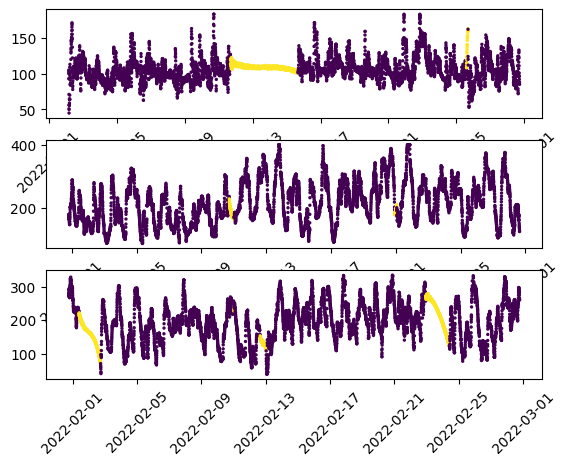

In [12]:
plt.subplots(3,1)
for i in range(0,3):
    subset = newData[newData['PatientId']==patIDs[i+3]].reset_index()
    print(subset.Value.count())
    plt.subplot(3,1,i+1)
    plt.scatter(subset.GlucoseDisplayTime, subset.Value, c=subset.missing, s=2)
    plt.xticks(rotation=45)

In [13]:
newData.to_csv("../../cephfs/cleanedData/2022-02_sampleFilled.csv", index=False)